In [2]:
# for initialization
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary

torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

## Info GAN

* Implementation of InfoGAN. Source code is mainly referenced by [Coursera](https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans) and [Github](https://github.com/Natsu6767/InfoGAN-PyTorch/tree/4586919f2821b9b2e4aeff8a07c5003a5905c7f9)

* First part is architecture of InfoGAN;
* Second part is training process of InfoGAN; 
* Third part is interpolation and manipulation of InfoGAN;

#### Generator architecture

* The architecture is exactly same as DCGAN
* The input noise is combination between z and c (conditional noise labels)

In [3]:
#%% generator structure is similar to DCGAN
class Generator(nn.Module):
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    return torch.randn(n_samples, input_dim, device=device)

# quick overview of generator operation
gen = Generator(input_dim=20)
print(summary(gen,(10,20)))
z = torch.rand(10,20).to(device='cuda')
gen_output = gen(z)
print("Generator output shape is {}".format(gen_output.shape))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [10, 1, 28, 28]           --
├─Sequential: 1-1                        [10, 1, 28, 28]           --
│    └─Sequential: 2-1                   [10, 256, 3, 3]           --
│    │    └─ConvTranspose2d: 3-1         [10, 256, 3, 3]           46,336
│    │    └─BatchNorm2d: 3-2             [10, 256, 3, 3]           512
│    │    └─ReLU: 3-3                    [10, 256, 3, 3]           --
│    └─Sequential: 2-2                   [10, 128, 6, 6]           --
│    │    └─ConvTranspose2d: 3-4         [10, 128, 6, 6]           524,416
│    │    └─BatchNorm2d: 3-5             [10, 128, 6, 6]           256
│    │    └─ReLU: 3-6                    [10, 128, 6, 6]           --
│    └─Sequential: 2-3                   [10, 64, 13, 13]          --
│    │    └─ConvTranspose2d: 3-7         [10, 64, 13, 13]          73,792
│    │    └─BatchNorm2d: 3-8             [10, 64, 13, 13]          128

#### Discriminator structure

* The only difference between InfoGAN discriminator is the additional output of 'q_layer': output labels
* The input to discriminator is only image, the output is twofold. The first is traditional adversarial loss. The second is latent code output.
* the output of q_layer is c_dim*2. One part of variable is mean and another part of variable is standard deviation

In [4]:
class Discriminator(nn.Module):
    # c_dim is for latent code c
    def __init__(self, im_chan=1, hidden_dim=64, c_dim=10):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
        )
        # d layer is discriminator to determine true or false
        self.d_layer = self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
        # q layer return classification for labels?
        self.q_layer = nn.Sequential(
            self.make_disc_block(hidden_dim * 2, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 2 * c_dim, kernel_size=1, final_layer=True)
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        intermediate_pred = self.disc(image)
        disc_pred = self.d_layer(intermediate_pred)
        q_pred = self.q_layer(intermediate_pred)
        return disc_pred.view(len(disc_pred), -1), q_pred.view(len(q_pred), -1)

disc = Discriminator()
print(summary(disc,(10,1,28,28)))
a = torch.rand(10,1,28,28).to(device='cuda')
disc_pred, q_pred = disc(a)
print("Discriminator prediction shape is {}".format(disc_pred.shape))
print("Discriminator feature prediction shape is {}".format(q_pred.shape))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [10, 1]                   --
├─Sequential: 1-1                        [10, 128, 5, 5]           --
│    └─Sequential: 2-1                   [10, 64, 13, 13]          --
│    │    └─Conv2d: 3-1                  [10, 64, 13, 13]          1,088
│    │    └─BatchNorm2d: 3-2             [10, 64, 13, 13]          128
│    │    └─LeakyReLU: 3-3               [10, 64, 13, 13]          --
│    └─Sequential: 2-2                   [10, 128, 5, 5]           --
│    │    └─Conv2d: 3-4                  [10, 128, 5, 5]           131,200
│    │    └─BatchNorm2d: 3-5             [10, 128, 5, 5]           256
│    │    └─LeakyReLU: 3-6               [10, 128, 5, 5]           --
├─Sequential: 1-2                        [10, 1, 1, 1]             --
│    └─Conv2d: 2-3                       [10, 1, 1, 1]             2,049
├─Sequential: 1-3                        [10, 20, 1, 1]            --
│ 

#### Play around with normal function in PyTorch

The logic is really similar to VAE

* logrithmatic of a normal pdf value: $log(f(x_i;\mu,\sigma^2)) = -\frac{n}{2}log(2\pi) - \frac{n}{2}log(\sigma^2) - \frac{1}{2\sigma^2}\sum (x_i-\mu)^2$.\
$Log(pdf)$: the higher probability density, the value is more positive and close to 0. The lower probability density is, the more negative value $log(pdf)$ will be. Please refer to ln(x) function. Log likelihood function is always negative. This means $Loss = adv_loss - loglikelihood$
* [PyTorch source code](https://pytorch.org/docs/stable/_modules/torch/distributions/normal.html#Normal.log_prob): for how to use Info loss
* [Equation derivation video explanation](https://www.youtube.com/watch?v=qIJez258ri8&t=1650s)
* [Correction of equation proof](https://www.depthfirstlearning.com/2018/InfoGAN)
* Construct a normal distribution $N \sim (\mu,\sigma)$, where $\mu$ is discriminator output mean; $\sigma$ is discriminator output variance 
* This discriminator output normal distribution should follow similar probability density fucntion with latent code $c$;
* The logic behind Info loss is based on **Kullback-Leibler Divergence**: measuring the discrepancies between two statistical distribution.


The mathmatics behind Mutual information bound:

In [5]:
from torch.distributions.normal import Normal
# create standard normal distribution
c = Normal(0,1)
# output cdf (cumulative distribution) given random variable (1,2,0.1)
print(c.cdf(torch.arange(1,2,0.1)))
# output log normal probability of random variable
# supposing latent code is 0,0, then the two probability should be really close. Since 0 is the mean of std gaussain N(0,1)
print(c.log_prob(torch.Tensor([0,0])).mean())
# as we modify latent code far away from std gaussian, the Info Loss will become higher
print(c.log_prob(torch.Tensor([1,1])).mean())
print(c.log_prob(torch.Tensor([2,2])).mean())
print(c.log_prob(torch.Tensor([-1,1])).mean())

tensor([0.8413, 0.8643, 0.8849, 0.9032, 0.9192, 0.9332, 0.9452, 0.9554, 0.9641,
        0.9713])
tensor(-0.9189)
tensor(-1.4189)
tensor(-2.9189)
tensor(-1.4189)


#### Training process setup

* Define combinating vector: combine noise vector z and latent code c;
* Define adversarial loss function
* Define extra loss function - c_criterion
* Discriminator learning rate is lower than generator

In [8]:
# combine latent code c and noise vector z
def combine_vectors(x, y):
    combined = torch.cat([x.float(), y.float()], 1)
    return combined
from torch.distributions.normal import Normal

# adversarial loss function
adv_criterion = nn.BCEWithLogitsLoss()

# define InfoGAN loss
# c_labels, disc_q_mean, disc_q_logvar
# disc_q_mean
c_criterion = lambda c_true, mean, logvar: Normal(mean, logvar.exp()).log_prob(c_true).mean()
c_lambda = 0.1

# regular parameters setup
mnist_shape = (1, 28, 28)
n_epochs = 10
z_dim = 64
c_dim = 2
display_step = 500
batch_size = 128
# InfoGAN uses two different learning rates for the models
# discriminator should be learning slower than generator
d_lr = 2e-4
g_lr = 1e-3
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

gen = Generator(input_dim=z_dim + c_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=g_lr)
disc = Discriminator(im_chan=mnist_shape[0], c_dim=c_dim).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=d_lr)

#### Training process begins:
* general loss = adversarial loss - lambda * mutal_information; We want to maximize the disentaglement

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)
        # get the noise vector
        c_labels = get_noise(cur_batch_size, c_dim, device=device)    
        disc_opt.zero_grad() 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        # Combine the noise vectors and the one-hot labels for the generator
        noise_and_labels = combine_vectors(fake_noise, c_labels)
        # Generate the conditioned fake images
        fake = gen(noise_and_labels)
        
        # Get the discriminator's predictions
        disc_fake_pred, disc_q_pred = disc(fake.detach())
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        disc_real_pred, _ = disc(real)
        disc_fake_loss = adv_criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = adv_criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        # Info GAN new loss function
        disc_loss = (disc_fake_loss + disc_real_loss) / 2 - c_lambda * mutual_information
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()
        disc_fake_pred, disc_q_pred = disc(fake)
        disc_q_mean = disc_q_pred[:, :c_dim]
        disc_q_logvar = disc_q_pred[:, c_dim:]
        mutual_information = c_criterion(c_labels, disc_q_mean, disc_q_logvar)
        gen_loss = adv_criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) - c_lambda * mutual_information
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1

#### Interpretation and interpolation

* The tweak of latent code will manipulate of generated images
* first label --> one image
* second label --> another image
* interpolation label --> interpolation label between first and second image generation

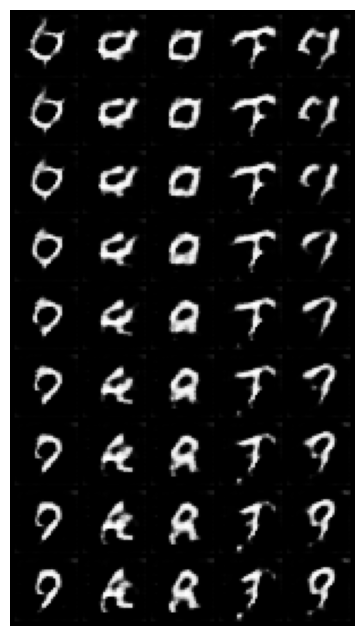

In [12]:
gen = gen.eval()
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
n_view = 5
interpolation_noise = get_noise(n_view, z_dim, device=device).repeat(n_interpolation, 1)
first_label = get_noise(1, c_dim).repeat(n_view, 1)[None, :]
second_label = first_label.clone()

# first seed to determine the number
first_label[:, :, 0] =  -2
second_label[:, :, 0] =  2


# Calculate the interpolation vector between the two labels
percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None, None]
interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
interpolation_labels = interpolation_labels.view(-1, c_dim)

# Combine the noise and the labels
noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
fake = gen(noise_and_labels)
plt.figure(figsize=(8, 8))
show_tensor_images(fake, num_images=n_interpolation * n_view, nrow=n_view, show=False)
_ = plt.axis('off')

#### Only tweak the latent code instead of gaussian space

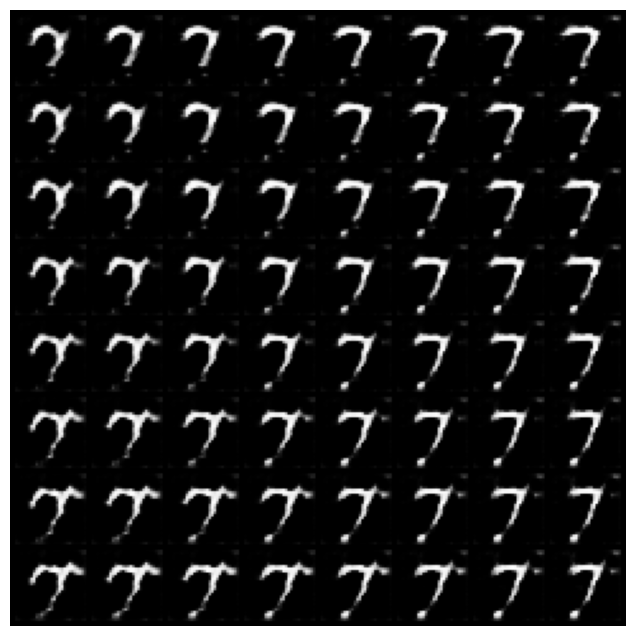

In [13]:
import math

### Change me! ###
n_interpolation = 8 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation * n_interpolation, 1)
first_label = get_noise(1, c_dim).repeat(n_interpolation * n_interpolation, 1)

# Calculate the interpolation vector between the two labels
first_label = torch.linspace(-2, 2, n_interpolation).repeat(n_interpolation)
second_label = torch.linspace(-2, 2, n_interpolation).repeat_interleave(n_interpolation)
interpolation_labels = torch.stack([first_label, second_label], dim=1) 

# Combine the noise and the labels
noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
fake = gen(noise_and_labels)
plt.figure(figsize=(8, 8))
show_tensor_images(fake, num_images=n_interpolation * n_interpolation, nrow=n_interpolation, show=False)

_ = plt.axis('off')